In [24]:
import numpy as np
import xarray as xr
import pandas as pd

import xmitgcm
import ecco_v4_py as ecco
import swot_ssh_utils as swot

import sys

from scipy.spatial import KDTree
import matplotlib.pyplot as plt
%matplotlib inline

### Load in LLC90 Grid

In [25]:

data_dir = '/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956'
xcfile=data_dir+'/XC.data'
fb = open(xcfile, "rb")
nx=90
ny=90*13
xc=np.fromfile(fb,dtype='>f')


ycfile=data_dir+'/YC.data'
fb = open(ycfile, "rb")
nx=90
ny=90*13
yc=np.fromfile(fb,dtype='>f') # xc, yc in shape 90x1170 = 105,300 x 1


### Load in hFacC to 0 out over land ###

# try RDMDS from mitgcm utils
# hfaccfile=data_dir+'/hFacC.data'
# fb = open(hfaccfile, "rb")
# nx=90
# ny=90*13
# hfacc=np.fromfile(fb,dtype='>f')

# hfacc = hfacc.reshape(50,nx, ny)
#plt.pcolor(hfacc[0,:,:])

### Read in SWOT Data

/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:                                (num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
    latitude_nadir                         (num_lines) float64 ...
    longitude_nadir                        (num_lines) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/96)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    sea_state_bias_cor                     (num_lines, num_pixels) float32 ...
    sea_state_bias_cor_2                   (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-08-30T05:26:16Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   JPL
    references:                                    V1.1
    equator_time:                                  2023-07-08T23:33:55.205000Z
    equator_longitude:                             125.31
    product_version:                               01

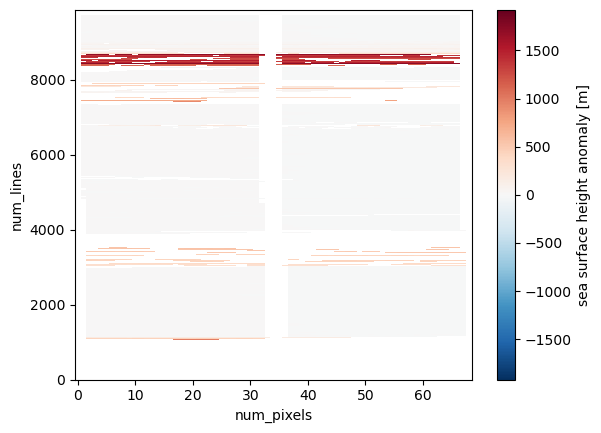

In [26]:

pth = '/home/shoshi/swot/'
#filename = 'SWOT_L2_LR_SSH_Expert_577_019_20230709T212220_20230709T220717_PIB0_01.nc'
filename = 'SWOT_L2_LR_SSH_Expert_576_021_20230708T231352_20230708T235844_PIB0_01.nc'

ds_swot1 = xr.open_dataset(pth + filename)

ds_swot1.ssha_karin_2.plot() # ssh karin NaN if over land 

ds_swot1

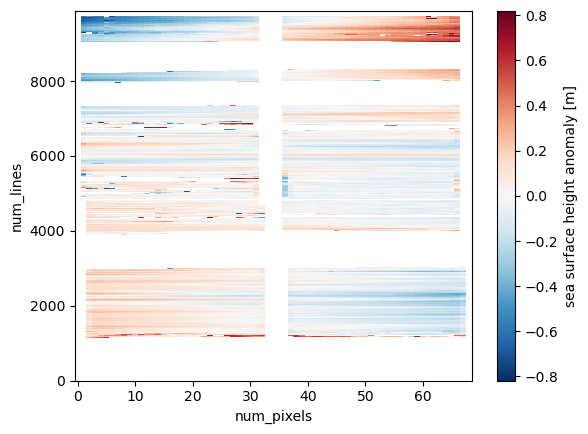

In [27]:

# apply corrections
ssha = ds_swot1.ssha_karin_2
flag = ds_swot1.ancillary_surface_classification_flag
ssha = np.where(flag == 0, ssha, np.nan)

distance = ds_swot1.cross_track_distance.values

ssha_1 = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )

ds_swot1.ssha_karin_2.values = ssha_1

ds_swot1.ssha_karin_2.plot()


In [28]:
# get timestamp from filename
starttime = filename.split('_')[7] # second input file starttime

year = starttime[:4]
month = starttime[4:6]
day = starttime[6:8]
hour = starttime[9:11]
minute = starttime[11:13]
sec = starttime[13:]


hour_start = np.datetime64(year + '-' + month + '-' + day + 'T' + hour)
hour_end = hour_start + np.timedelta64(1,'h')

hour_start, hour_end


(numpy.datetime64('2023-07-08T23','h'), numpy.datetime64('2023-07-09T00','h'))

In [29]:
# convert to pandas dataframe
df_swot1 = ds_swot1.to_dataframe()
#df_swot2 = ds_swot2.to_dataframe()


# reset index so can easily combine multiple dfs 
df_swot1.reset_index(inplace = True)
#df_swot2.reset_index(inplace = True)


# select data in current hour
df_swot1 = df_swot1[np.logical_and(hour_start <= df_swot1.time, df_swot1.time <= hour_end)]
#df_swot2 = df_swot2[np.logical_and(hour_start <= df_swot2.time, df_swot2.time <= hour_end)]


# combine data from both files to fill the hour
#df_swot = pd.concat([df_swot1, df_swot2])
df_swot = df_swot1

# if there are three input files
# if num_input_files == 3:
#     filename3 = sys.argv[3]
#     ds_swot3 = xr.open_dataset(swot_data_dir + filename3)
#     df_swot3 = ds_swot3.to_dataframe()
#     df_swot3.reset_index(inplace = True)
#     df_swot3 = df_swot3[np.logical_and(hour_start <= df_swot3.time, df_swot3.time <= hour_end)]
#     df_swot = pd.concat([df_swot, df_swot3])


# convert longitude from [0,360] to [-180, 180] to match convention in LLC90
# https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
df_swot['longitude'] = (df_swot['longitude'] + 180) % 360 - 180





/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


### Regridding
num_lines, num_pixels --> lat/lon (SWOT) --> lat/lon (LLC90) --> cell/face

In [30]:
### Regridding with KD Tree ###

import time
start_time = time.time()

# For each swot point, find nearest llc point
llc_lats = yc
llc_lons = xc

llc_coords = np.c_[llc_lats, llc_lons]
swot_coords = np.c_[df_swot['latitude'], df_swot['longitude']]

kd_tree = KDTree(llc_coords)
distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)


# add flag to swot df
df_swot.insert(4, "llc_coords_index", nearest_swot_index_in_llc.astype('int'), True)


# groupby llc (lat, lon) index to get average (and stddev) swot ssh
gb = df_swot.groupby(['llc_coords_index'])
counts = gb.size().to_frame(name='counts')
gb_stats = (counts
.join(gb.agg({'ssha_karin_2': 'mean'}).rename(columns={'ssha_karin_2': 'ssha_karin_2_mean'}))
.join(gb.agg({'ssha_karin_2': 'std'}).rename(columns={'ssha_karin_2': 'ssha_karin_2_std'}))
.reset_index()
)

# convert lats_flag, lons_flag from indices to actual lat and lon values
indices = gb_stats.llc_coords_index.values

write_llc_lats = llc_lats[indices]
write_llc_lons = llc_lons[indices]

# insert lats and lons into stats df
gb_stats.insert(2, "latitude", write_llc_lats, True)
gb_stats.insert(3, "longitude", write_llc_lons, True)



end_time = time.time()

print("Done in {} seconds".format(end_time - start_time))


gb_stats

Done in 0.9570894241333008 seconds


In [32]:
gb_stats.to_csv('gb_stats_old.csv', index=False)

In [8]:
# side 0 and side 1 are the same so can just take one of them

# df_side0 = df_swot.iloc[df_swot.index.get_level_values('num_sides') == 0]
# df_side1 = df_swot.iloc[df_swot.index.get_level_values('num_sides') == 1]

# test=df_side1.reset_index()
# test['num_sides'] = 0

# test.set_index(['num_lines', 'num_pixels', 'num_sides'], inplace=True)
# #test.compare(df_side0)

### Merge with Entire Global Domain

In [13]:
# create global llc90 df
global_df = pd.DataFrame({'latitude': yc.astype('f8'), 'longitude': xc.astype('f8')})

# merge with df over swot swath
gb_stats['latitude'] = gb_stats['latitude'].astype('f8')
gb_stats['longitude'] = gb_stats['longitude'].astype('f8')
combined_df = global_df.merge(gb_stats, how = 'left', on = ['latitude', 'longitude'])

combined_df



,latitude,longitude,llc_coords_index,counts,ssha_karin_2_mean,ssha_karin_2_std
0,0.0,0.0,NaN,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN,NaN,NaN
2,0.0,0.0,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,NaN,NaN,NaN
4,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
105295,0.0,0.0,NaN,NaN,NaN,NaN
105296,0.0,0.0,NaN,NaN,NaN,NaN
105297,0.0,0.0,NaN,NaN,NaN,NaN
105298,0.0,0.0,NaN,NaN,NaN,NaN


In [14]:
# double check that all lat lon pairs are actually pairs in the llc grid

llc_coords = global_df[['latitude', 'longitude']].values
gb_coords = gb_stats[['latitude', 'longitude']].values

tf = []
for i in range(gb_coords.shape[0]):
    tf.append(gb_coords[i] in llc_coords)

    
np.unique(tf)

array([ True])

In [11]:
# combined_df[~combined_df['ssha_karin_2_mean'].isna()]

#len(np.unique(combined_df['ssha_karin_2_mean']))

### Plot 

In [12]:
#ds_swot1

Text(0.5, 1.0, 'SWOT SSH')

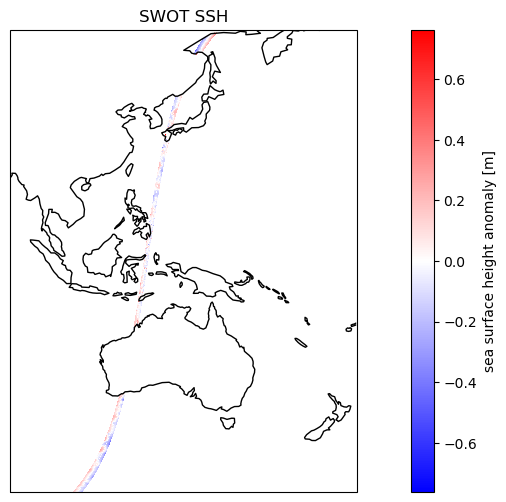

In [15]:
# plot SWOT SSH data

import cartopy.crs as ccrs

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_swot1.ssha_karin_2.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", cmap='bwr',add_colorbar=True
)
ax.coastlines()
ax.set_ylim([-60, 60])
ax.set_xlim([90,180])
plt.title('SWOT SSH')

Text(0.5, 1.0, 'SSH on LLC Grid')

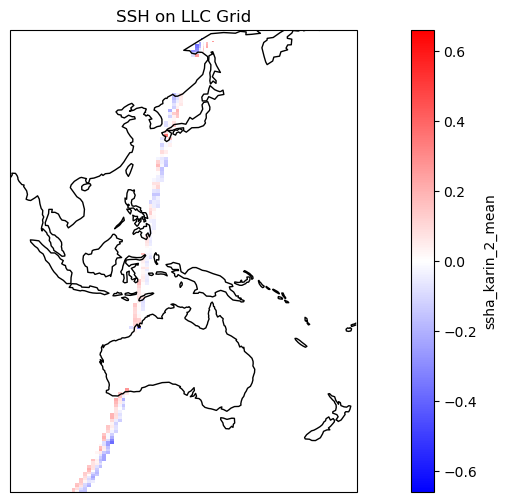

In [16]:
# plot SSH regridded for LLC grid

# create xarray from regridded data
ds_out = gb_stats.set_index(['latitude', 'longitude']).to_xarray()
#ds_out = combined_df.set_index(['latitude', 'longitude']).to_xarray()
ds_out


plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_out.ssha_karin_2_mean[:,:].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap='bwr'
)
ax.coastlines()
ax.set_ylim([-60, 60]);
ax.set_xlim([90,180])
plt.title('SSH on LLC Grid')


In [21]:
#ds_out.ssha_karin_2_mean[:,:].shape
#ds_out

tmp_ssha = ds_out.ssha_karin_2_mean.values
tmp_ssha[~np.isnan(tmp_ssha)]

array([-3.29400952e-01,  2.70947131e-01,  7.90327311e-02,  4.66856472e-01,
        1.70938769e-01, -1.51598635e-01,  9.09746716e-02,  3.65825816e-01,
        1.22781252e-01,  3.74336447e-02,  1.58218197e-01,  1.98197129e-01,
        2.22308779e-02, -6.13279530e-02,  5.62899787e-02,  2.09332686e-01,
        1.28884409e-01, -4.14096581e-03, -5.53832063e-02,  1.92207410e-01,
        1.46116405e-01,  9.65448134e-02, -1.94820413e-02, -1.57295708e-01,
        1.09766965e-01,  2.79140079e-02, -7.77154750e-02, -1.39989078e-01,
        1.57572212e-01,  7.21362465e-02, -5.44033609e-02, -1.39408871e-01,
       -1.31993006e-01,  1.04978611e-01,  4.71446528e-02, -6.20523524e-02,
       -1.45760313e-01,  1.00886912e-01,  6.31054479e-02, -2.17993227e-02,
       -1.04078949e-01, -1.01640557e-01,  1.50413330e-01,  5.43431444e-02,
       -3.09696638e-02, -1.11895058e-01,  1.82433448e-01,  1.50876742e-01,
        3.73350949e-02, -6.28321430e-02,  2.25043540e-01,  9.90738287e-02,
        1.51476314e-02, -

### Write Output

In [16]:
# peek into sst input file to check required formatting

# data_dir = '/scratch/08382/shoshi/MITgcm_c68p/llc90/eccov4r4_with_tides_stampede2/input/data_constraints/input_sst/'

# sst = ecco.read_llc_to_tiles(data_dir, 'reynolds_oiv2_r1_mar2018_simasked_1992')
# sst[sst == -9999] = np.nan
# ecco.plot_tiles(sst, layout='latlon',rotate_to_latlon=True,show_tile_labels=False, show_colorbar=True);
 

In [18]:
# change nans to -9999
combined_df.loc[combined_df['counts'].isna(), 'counts'] = -9999
combined_df.loc[combined_df['ssha_karin_2_mean'].isna(), 'ssha_karin_2_mean'] = -9999
combined_df.loc[combined_df['ssha_karin_2_std'].isna(), 'ssha_karin_2_std'] = -9999


# insert timestamp
combined_df.insert(0, "DateTime", pd.Timestamp(year=int(year), month=int(month), day=int(day), 
                                               hour=int(hour)), True)

# write in compact binary format
out_dir = './regridded_data_1day_repeat/'

#len(combined_df['ssha_karin_2_mean'].values)

fname = 'swot' + year + month + day + hour + '.bin'
#xmitgcm.utils.write_to_binary(combined_df['ssha_karin_2_mean'].values, out_dir + fname)

105300

In [4]:
# fake data for lab sea tutorial
tmp = 16*20*24*365 # nx x ny x nt (number of hours in a year)
#old = 8960 - 8760 is number of hours in a year i wonder if that was it
lab_sea_ssh = np.random.uniform(low=-0.6, high=0.6, size=(tmp,))


out_dir = './regridded_data_1day_repeat/'
fname = 'labsea_ssh.bin'
xmitgcm.utils.write_to_binary(lab_sea_ssh, out_dir + fname)

load_binary_array: loading file regridded_data_1day_repeat/swot2023070823.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


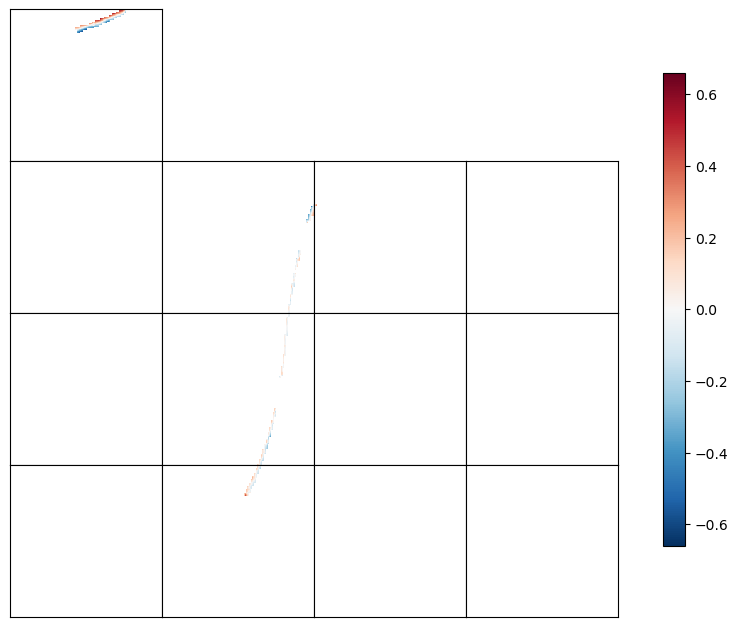

In [18]:
# read back in because we're curious
ssha = ecco.read_llc_to_tiles(out_dir, fname)
ssha[ssha == -9999] = np.nan
ecco.plot_tiles(ssha, layout='latlon',rotate_to_latlon=True,show_tile_labels=False, show_colorbar=True);
 

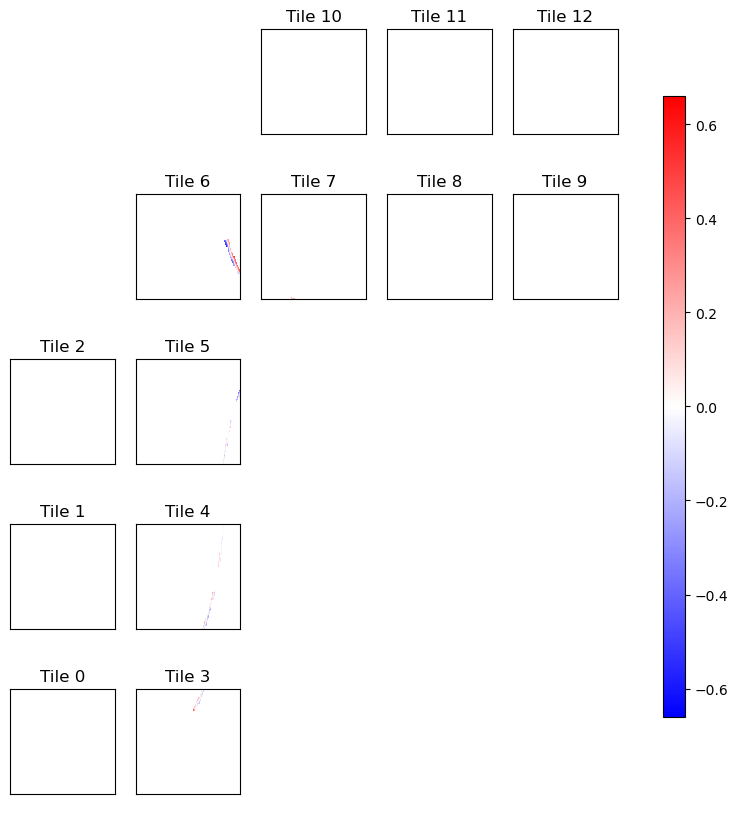

In [19]:
ecco.plot_tiles(ssha, \
                #cmin=32, \
                #cmax=35.5, \
                cmap='bwr', \
                show_colorbar=True);